In [14]:
import cv2 as cv
import numpy as np
import os
import time
from keras_facenet import FaceNet
from mtcnn import MTCNN

# Inicializar FaceNet y el detector MTCNN
modelo_facenet = FaceNet()
detector = MTCNN()

# Crear directorio para guardar datos si no existe
directorio_datos = "datos_captura"
if not os.path.exists(directorio_datos):
    os.makedirs(directorio_datos)

def capturar_rostros(nombre, num_fotos=15):
    # Crear un directorio específico para la persona
    ruta_persona = os.path.join(directorio_datos, nombre)
    if not os.path.exists(ruta_persona):
        os.makedirs(ruta_persona)
    
    # Inicializar la cámara
    captura = cv.VideoCapture(0)
    contador_fotos = 0
    
    while contador_fotos < num_fotos:
        _, fotograma = captura.read()
        fotograma_rgb = cv.cvtColor(fotograma, cv.COLOR_BGR2RGB)
        
        # Detectar rostros en el fotograma
        rostros_detectados = detector.detect_faces(fotograma_rgb)
        
        # Si hay al menos un rostro detectado
        if rostros_detectados:
            x, y, ancho, alto = rostros_detectados[0]['box']
            x, y = abs(x), abs(y)
            rostro = fotograma_rgb[y:y+alto, x:x+ancho]
            
            # Redimensionar y guardar la imagen del rostro
            rostro_redimensionado = cv.resize(rostro, (160, 160))
            ruta_foto = os.path.join(ruta_persona, f"{nombre}_{contador_fotos}.jpg")
            cv.imwrite(ruta_foto, cv.cvtColor(rostro_redimensionado, cv.COLOR_RGB2BGR))
            
            contador_fotos += 1
            print(f"Foto {contador_fotos} capturada para {nombre}")
            
            # Dibujar el rectángulo y mostrar el nombre
            cv.rectangle(fotograma, (x, y), (x + ancho, y + alto), (255, 0, 255), 2)
            cv.putText(fotograma, f"Captura {contador_fotos}/{num_fotos}", (x, y - 10),
                       cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2, cv.LINE_AA)
            time.sleep(0.5)

        # Mostrar el fotograma en la ventana
        cv.imshow("Captura de Rostros", fotograma)
        
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    
    captura.release()
    cv.destroyAllWindows()

def generar_embeddings(nombre):
    ruta_persona = os.path.join(directorio_datos, nombre)
    embeddings = []
    etiquetas = []
    
    for archivo in os.listdir(ruta_persona):
        ruta_imagen = os.path.join(ruta_persona, archivo)
        imagen = cv.imread(ruta_imagen)
        imagen_rgb = cv.cvtColor(imagen, cv.COLOR_BGR2RGB)
        rostro_redimensionado = cv.resize(imagen_rgb, (160, 160))
        
        # Obtener embeddings
        embedding = modelo_facenet.embeddings(np.expand_dims(rostro_redimensionado, axis=0))[0]
        embeddings.append(embedding)
        etiquetas.append(nombre)
    
    # Guardar embeddings y etiquetas
    np.savez_compressed(f"embeddings_{nombre}.npz", np.array(embeddings), np.array(etiquetas))
    print(f"Embeddings generados y guardados para {nombre}")

# Paso 1: Capturar imágenes
nombre = input("Ingresa el nombre para la captura de imágenes: ")
capturar_rostros(nombre)

# Paso 2: Generar y guardar embeddings
generar_embeddings(nombre)


Foto 1 capturada para bbbb
Foto 2 capturada para bbbb
Foto 3 capturada para bbbb
Foto 4 capturada para bbbb
Foto 5 capturada para bbbb
Foto 6 capturada para bbbb
Foto 7 capturada para bbbb
Foto 8 capturada para bbbb
Foto 9 capturada para bbbb
Foto 10 capturada para bbbb
Foto 11 capturada para bbbb
Foto 12 capturada para bbbb
Foto 13 capturada para bbbb
Foto 14 capturada para bbbb
Foto 15 capturada para bbbb
1/1 [==============================] - 0s 53ms/step
Embeddings generados y guardados para bbbb


Cargadas con éxito: 0 imágenes de la clase 'aitor'
Cargadas con éxito: 15 imágenes de la clase 'bbb'
Cargadas con éxito: 15 imágenes de la clase 'bbbb'
Error en itor_9.jpg: list index out of range
Cargadas con éxito: 14 imágenes de la clase 'itor'


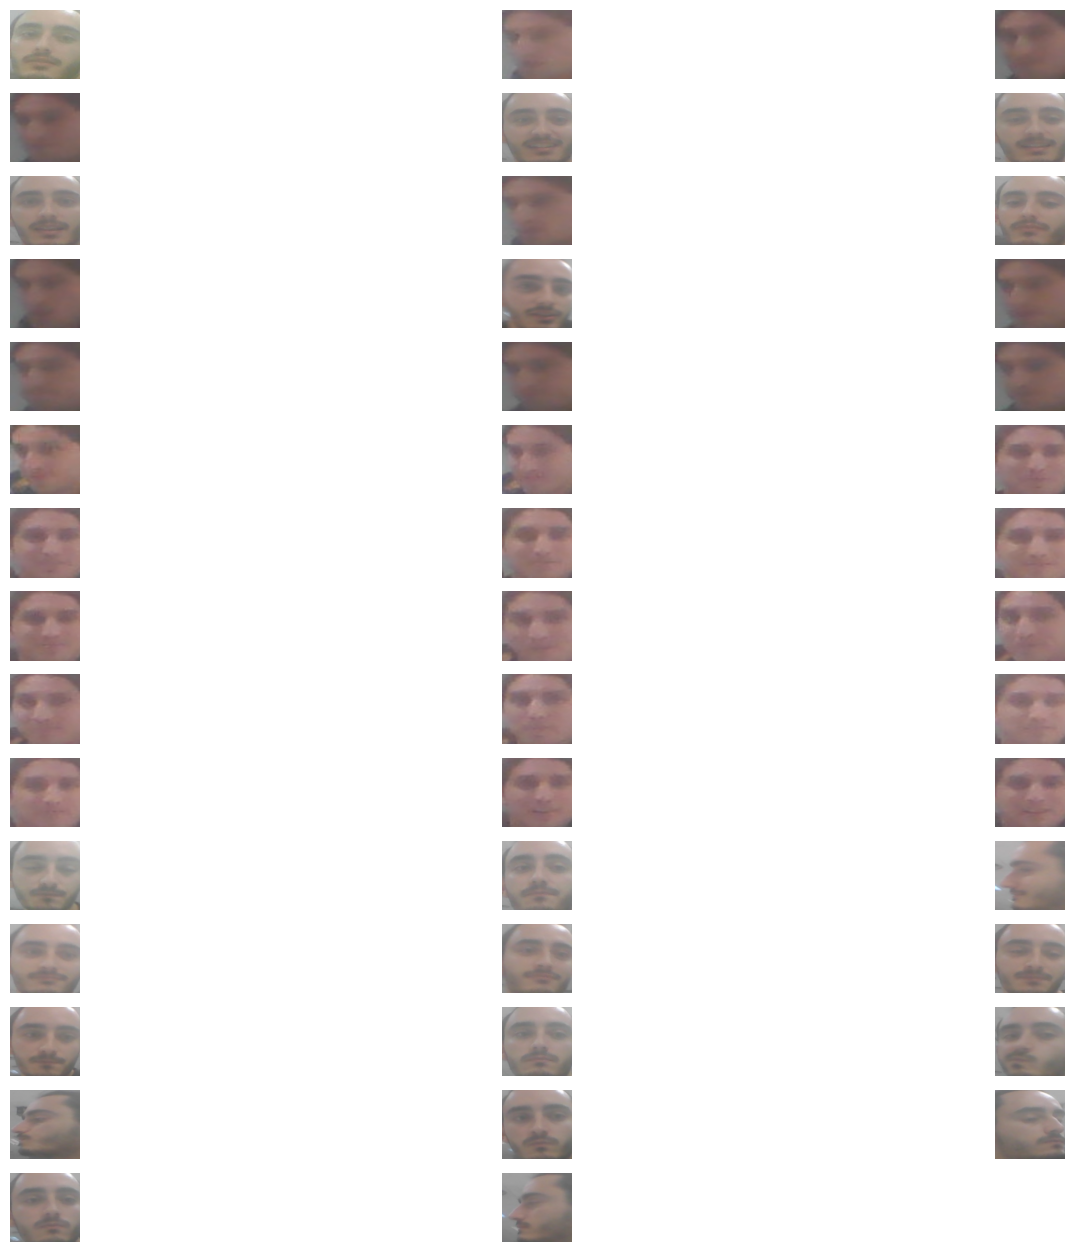

1/1 [==============================] - 0s 49ms/step
Embeddings guardados en ./embedding/faces_embeddings_done.npz


In [15]:
import os
import numpy as np
import cv2 as cv
from mtcnn import MTCNN
from keras_facenet import FaceNet
import matplotlib.pyplot as plt

class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160, 160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()
        self.facenet = FaceNet()  # Modelo FaceNet para obtener embeddings

    # Extrae el rostro de una imagen
    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        x, y, w, h = self.detector.detect_faces(img)[0]['box']
        x, y = abs(x), abs(y)
        face = img[y:y+h, x:x+w]
        face_arr = cv.resize(face, self.target_size)
        return face_arr

    # Carga todos los rostros de un directorio
    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = os.path.join(dir, im_name)
                single_face = self.extract_face(path)
                FACES.append(single_face)
            except Exception as e:
                print(f"Error en {im_name}: {e}")
                pass
        return FACES

    # Carga las clases y almacena los rostros con sus etiquetas
    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = os.path.join(self.directory, sub_dir)
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Cargadas con éxito: {len(labels)} imágenes de la clase '{sub_dir}'")
            self.X.extend(FACES)
            self.Y.extend(labels)
        
        return np.asarray(self.X), np.asarray(self.Y)

    # Genera y guarda los embeddings
    def save_embeddings(self, filename='faces_embeddings.npz'):
        EMBEDDED_X = [self.facenet.embeddings(np.expand_dims(face, axis=0))[0] for face in self.X]
        EMBEDDED_X = np.asarray(EMBEDDED_X)
        np.savez_compressed(filename, EMBEDDED_X, np.array(self.Y))
        print(f"Embeddings guardados en {filename}")

    # Visualiza algunas imágenes cargadas
    def plot_images(self):
        plt.figure(figsize=(18, 16))
        ncols = 3
        nrows = len(self.Y) // ncols + 1
        for num, image in enumerate(self.X):
            plt.subplot(nrows, ncols, num + 1)
            plt.imshow(image)
            plt.axis('off')
        plt.show()

# Inicializar la clase y procesar las imágenes
face_loader = FACELOADING("datos_captura")
X, Y = face_loader.load_classes()
face_loader.plot_images()
face_loader.save_embeddings("./embedding/faces_embeddings_done.npz")


In [ ]:
import cv2 as cv
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import pickle
from keras_facenet import FaceNet
from mtcnn import MTCNN

# Inicializar FaceNet y MTCNN
modelo_facenet = FaceNet()
detector = MTCNN()

# Cargar embeddings y etiquetas desde el archivo guardado
datos_embeddings = np.load("./embedding/faces_embeddings_done.npz")
X = datos_embeddings['arr_0']
Y = datos_embeddings['arr_1']

# Codificar las etiquetas
encoder = LabelEncoder()
Y_codificado = encoder.fit_transform(Y)
print(Y_codificado)
# Entrenar el modelo SVM
modelo_svm = SVC(kernel='linear', probability=True)
modelo_svm.fit(X, Y_codificado)

# Guardar el modelo SVM entrenado (opcional)
with open("./embedding/modelo_svm_entrenado.pkl", 'wb') as archivo_modelo:
    pickle.dump(modelo_svm, archivo_modelo)

# Iniciar la detección en tiempo real
cap = cv.VideoCapture(0)

while cap.isOpened():
    ret, fotograma = cap.read()
    if not ret:
        break

    fotograma_rgb = cv.cvtColor(fotograma, cv.COLOR_BGR2RGB)
    rostros_detectados = detector.detect_faces(fotograma_rgb)

    for rostro in rostros_detectados:
        x, y, ancho, alto = rostro['box']
        x, y = abs(x), abs(y)
        rostro_img = fotograma_rgb[y:y+alto, x:x+ancho]

        # Redimensionar el rostro y obtener el embedding
        rostro_redimensionado = cv.resize(rostro_img, (160, 160))
        embedding = modelo_facenet.embeddings(np.expand_dims(rostro_redimensionado, axis=0))[0]

        # Clasificar el embedding usando el modelo SVM
        prediccion = modelo_svm.predict([embedding])
        probabilidad = modelo_svm.predict_proba([embedding])[0]
        nombre_predicho = encoder.inverse_transform(prediccion)[0]

        # Dibujar el rectángulo y la etiqueta con el nombre y la probabilidad
        cv.rectangle(fotograma, (x, y), (x + ancho, y + alto), (255, 0, 255), 2)
        texto = f"{nombre_predicho} ({probabilidad.max()*100:.2f}%)"
        cv.putText(fotograma, texto, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2, cv.LINE_AA)

    # Mostrar el fotograma en tiempo real
    cv.imshow("Reconocimiento Facial en Tiempo Real", fotograma)

    # 'q' para salir
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2]
1/1 [==============================] - 0s 49ms/step
